# Группа: Лобачев Никита, Озерова Дарья, Павлеева Мария

#Данные и Библиотеки

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

In [2]:
insurance = pd.read_csv('insurance.csv')

In [3]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


#Статистические характеристики

In [4]:
# количество, среднее, среднеквадратическое отклонение, минимальное и максимальное значения, 25, 50, 75 процентили
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
insurance.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


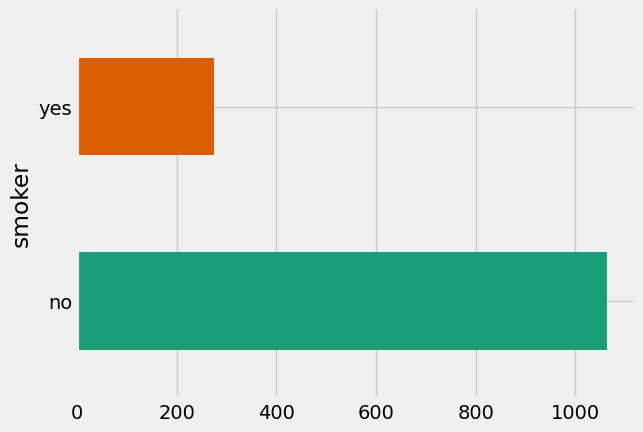

In [6]:
# количество курильщиков
from matplotlib import pyplot as plt
import seaborn as sns
insurance.groupby('smoker').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

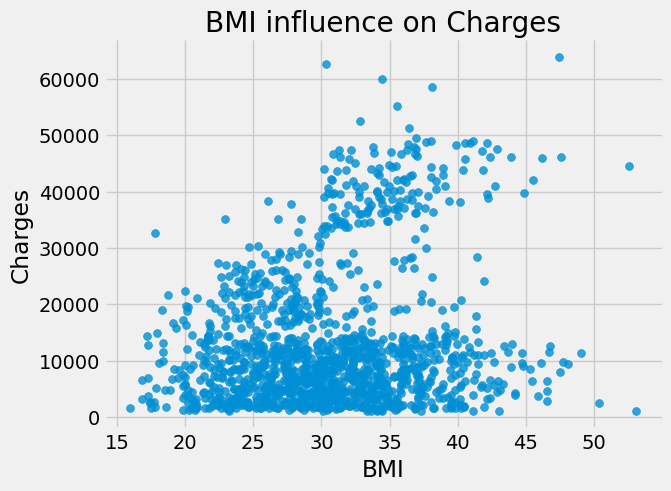

In [7]:
# как сумма страховки меняется в зависимости от значения имт
from matplotlib import pyplot as plt
insurance.plot(kind='scatter', x='bmi', y='charges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('BMI'); plt.ylabel('Charges');
plt.title('BMI influence on Charges');
plt.savefig("bmi-ch.png")

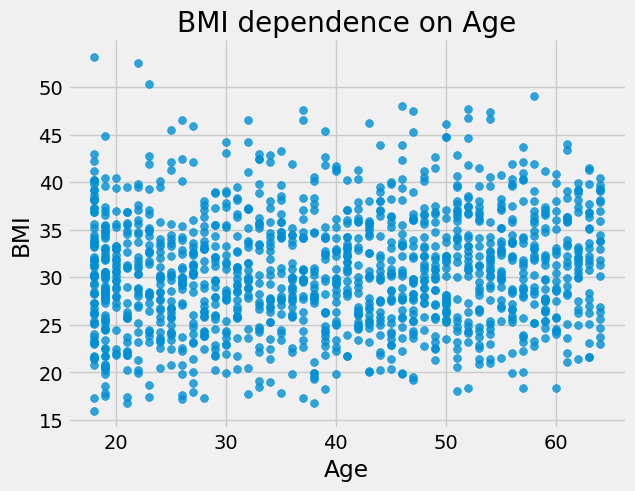

In [8]:
# как имт зависит от возраста
from matplotlib import pyplot as plt
insurance.plot(kind='scatter', x='age', y='bmi', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Age'); plt.ylabel('BMI');
plt.title('BMI dependence on Age');
plt.savefig("bmi-age.png")

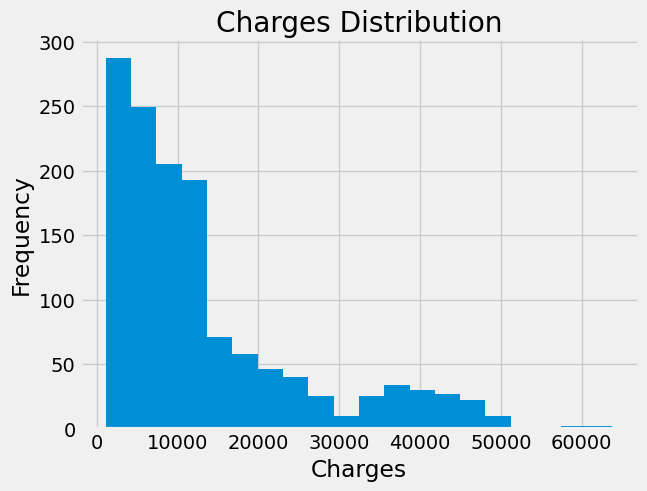

In [9]:
# распределение сумм страховок
from matplotlib import pyplot as plt
insurance['charges'].plot(kind='hist', bins=20, title='charges')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Charges'); plt.ylabel('Frequency');
plt.title('Charges Distribution');
plt.savefig("ch.png")

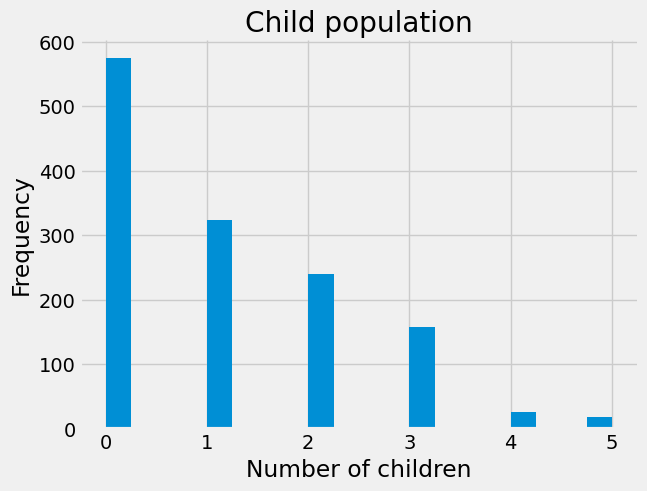

In [10]:
# распределение количества детей у людей из выборки
from matplotlib import pyplot as plt
insurance['children'].plot(kind='hist', bins=20, title='children')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of children'); plt.ylabel('Frequency');
plt.title('Child population');
plt.savefig("child.png")

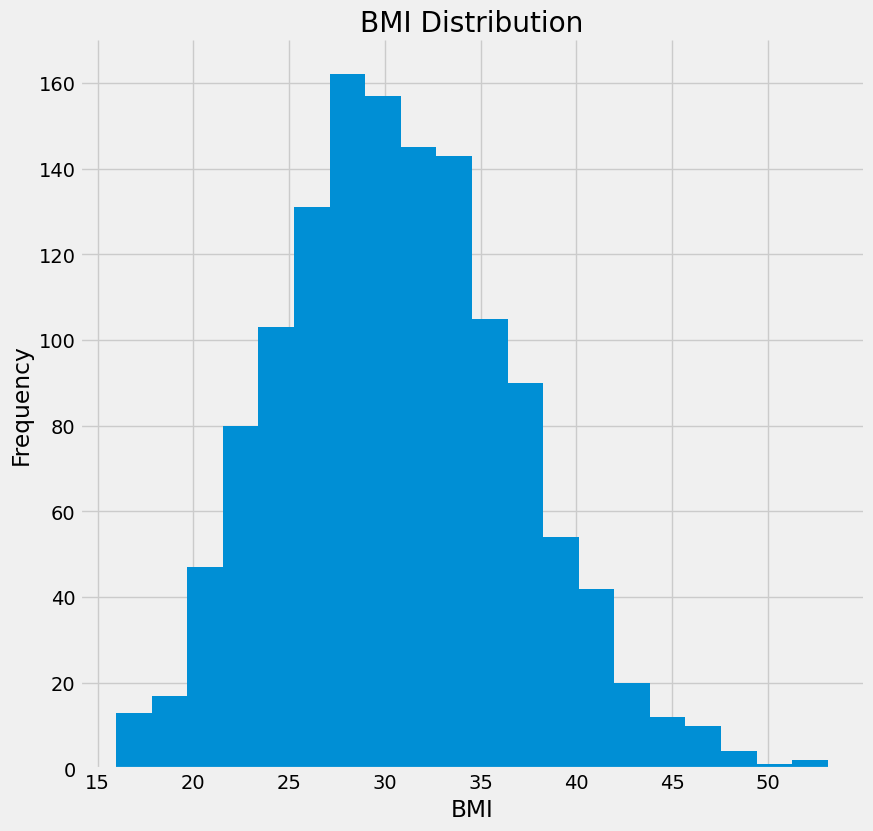

In [11]:
# Распределение ИМТ
from matplotlib import pyplot as plt
insurance['bmi'].plot(kind='hist', bins=20, title='bmi', figsize = (9, 9))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('BMI'); plt.ylabel('Frequency');
plt.title('BMI Distribution');
plt.savefig("bmi.png")

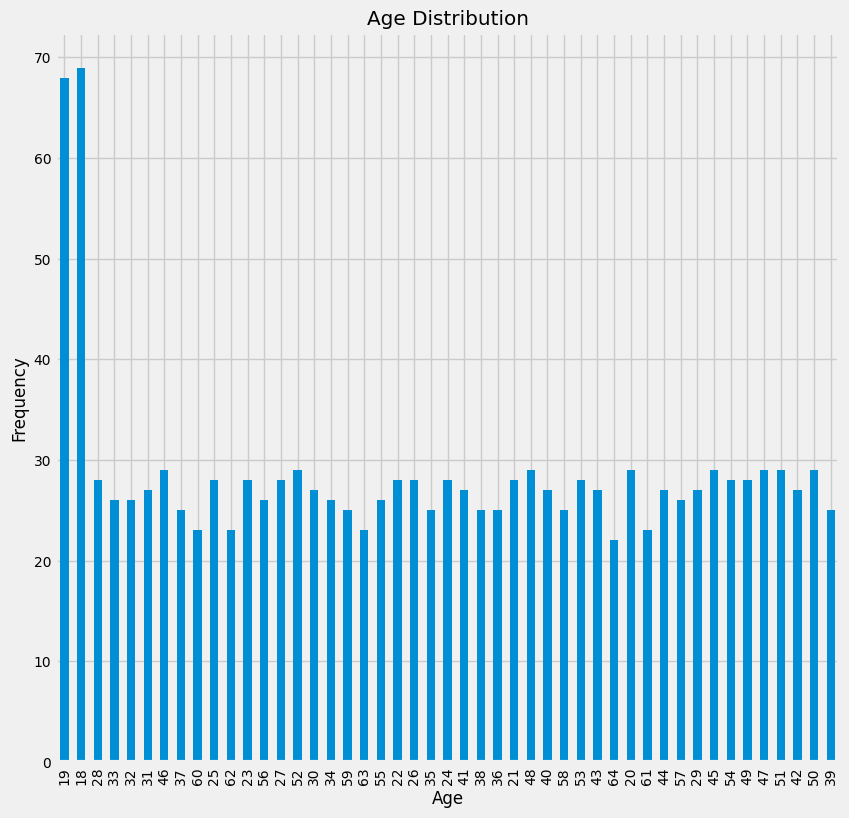

In [12]:
# распределение возрастов
insurance.age.sort_values()
plt.rcParams.update({'font.size':10})
insurance.age.value_counts()[insurance.age.unique()].plot(kind='bar', figsize = (9,9))
plt.xlabel('Age'); plt.ylabel('Frequency');
plt.title('Age Distribution');
plt.savefig("age.png")

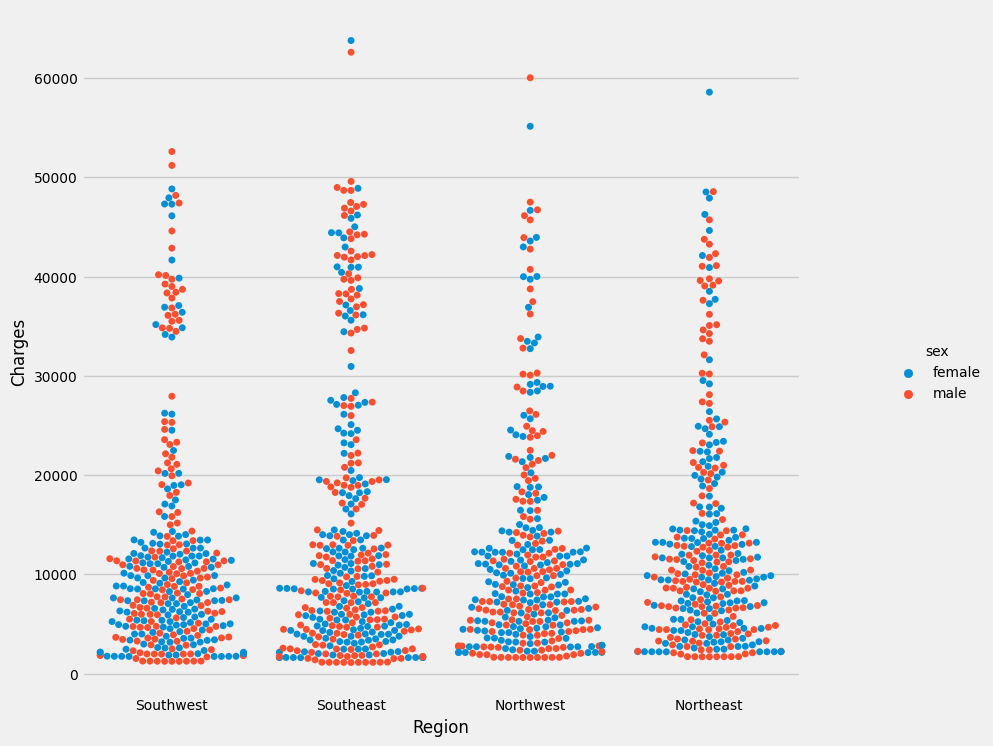

In [13]:
# распределение сумм страховок по регионам с учетом пола
import warnings
warnings.filterwarnings('ignore')
g = sns.catplot(data=insurance, x="region", y="charges", hue="sex", kind="swarm")
g.set_axis_labels("Region", "Charges")
g.set_xticklabels(["Southwest", "Southeast", "Northwest", "Northeast"])
g.set_titles("{col_name} {col_var}")
g.fig.set_size_inches(11,8)
plt.savefig("sex.png")

In [14]:
# матрица корреляции
# ins = pd.get_dummies(insurance, drop_first=True)
# hm = sns.heatmap(ins.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'YlGnBu')

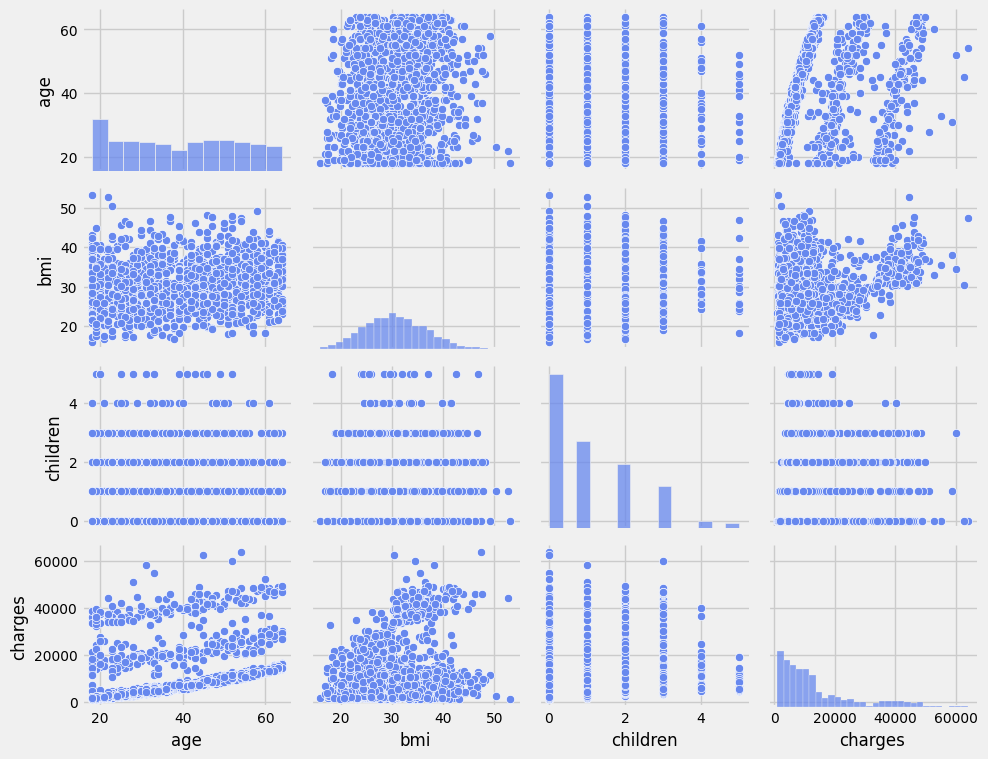

In [15]:
sns.set_palette('coolwarm')
pp = sns.pairplot(insurance, height=1.3)
pp.fig.set_size_inches(11,8)

In [16]:
# f, ax = plt.subplots(figsize=(8, 8))
# sns.despine(f, left=True, bottom=True)
# clarity_ranking = ["male", "female"]
# sns.scatterplot(x="age", y="bmi",
#                 hue="sex", size="charges",
#                 palette="ch:r=-.2,d=.3_r",
#                 hue_order=clarity_ranking,
#                 sizes=(1, 8), linewidth=0,
#                 data=insurance, ax=ax)


# Линейная регрессия

In [17]:
# назначение объясняемой переменной и объясняющих переменных
y = insurance['charges']
X = insurance.drop(columns=['charges'])

In [18]:
# обработка категориальных признаков и добавление свободного коэфф
X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)

In [19]:
# обучение модели
model = sm.OLS(y,X)
results = model.fit()

In [20]:
print(results.params)

const              -11938.538576
age                   256.856353
bmi                   339.193454
children              475.500545
sex_male             -131.314359
smoker_yes          23848.534542
region_northwest     -352.963899
region_southeast    -1035.022049
region_southwest     -960.050991
dtype: float64


In [21]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:17:26   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

# Мультиколлинеарность

In [22]:
# VIF
pd.DataFrame(np.array([variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]).reshape(1, -1), columns=list(X.columns[1:]))

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,1.016822,1.10663,1.004011,1.0089,1.012074,1.518823,1.65223,1.529411


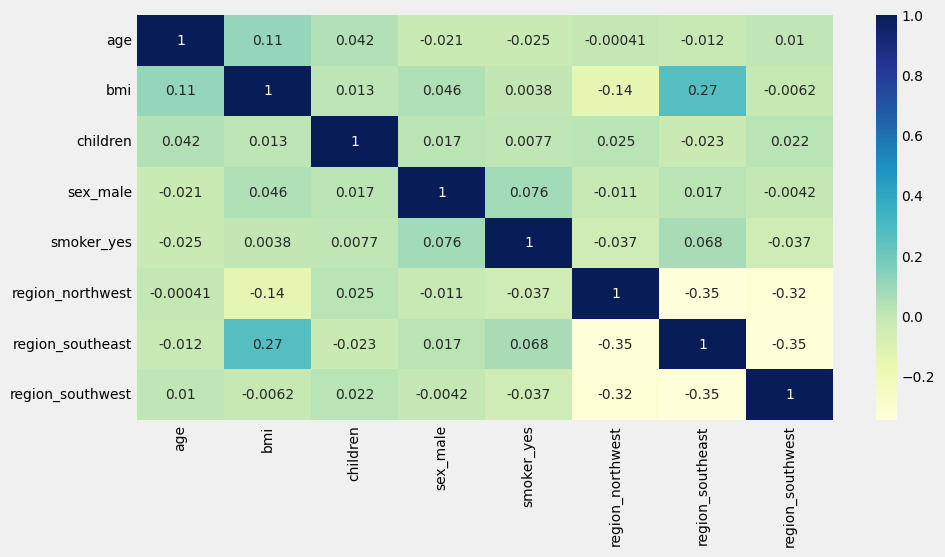

<Figure size 640x480 with 0 Axes>

In [23]:
# матрица корреляции
# print(X.corr())
fig, ax = plt.subplots(figsize=(10, 5))
dataplot = sns.heatmap(X.drop(columns=['const']).corr(), cmap="YlGnBu", annot=True)
plt.show()
plt.savefig("mult1.png")

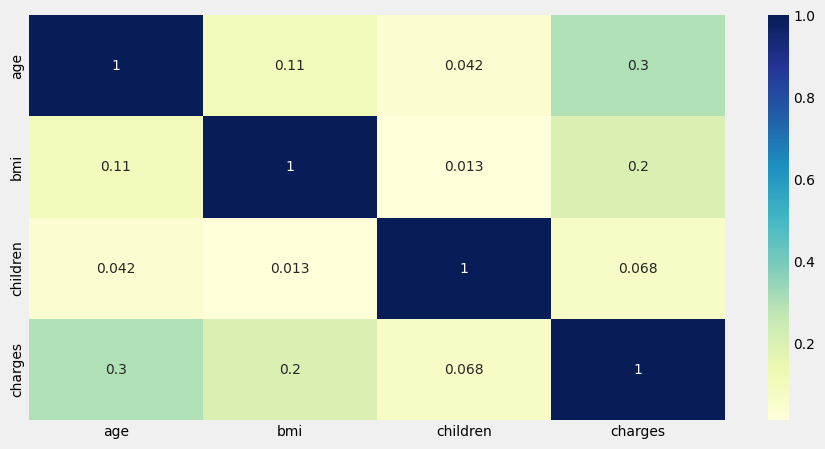

<Figure size 640x480 with 0 Axes>

In [24]:
# матрица корреляции без категориальных фичей
fig, ax = plt.subplots(figsize=(10, 5))
dataplot = sns.heatmap(insurance.corr(), cmap="YlGnBu", annot=True)
plt.show()
plt.savefig("mult2.png")

$\textbf{Судя по низким значениям VIF и графику корреляции, мультиколлинеарности нет.}$

# Гетероскедастичность

In [25]:
#для визуального анализа
for col in X.drop(columns=['const']).columns:
    fig = px.scatter(title=col, x=X[col], y=np.abs(results.resid))
    fig.show()

In [26]:
# Тест Бройша-Пагана
pd.DataFrame(np.array(het_breuschpagan(results.resid, X)).reshape(1, -1), columns=['lm', 'lm_pvalue', 'fvalue', 'f_pvalue'])

,lm,lm_pvalue,fvalue,f_pvalue
0,121.743601,1.446718e-22,16.628612,1.145606e-23


$ 1.446718e-22 \leq 0.05$ $\textbf{P-value меньше чем}$ $α=0.05$ $\implies$ $\textbf{отвергаем}$ $H_0$ $\implies$ $\textbf{есть условная гетероскедастичность.}$

$\textbf{Для снижения гетероскедастичности в пункте "Другие наборы переменных" заменим признаки "age" и "bmi" на их прологарифмированные значения.}$


#Автокорреляция ошибок

In [27]:
# H0 - отсутствие автокорреляции
# Ha - автокорреляция 1-го порядка
# The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation.
# The closer to 4, the more evidence for negative serial correlation.
durbin_watson(results.resid)

2.088422998667309

$\textbf{Значение статистики приблизительно равно 2}$ $\bf\implies$ $\textbf{не ожидаем автокорреляцию первого порядка.}$

In [28]:
# H0 - отсутствие автокорреляции
# Ha - автокорреляция 1-го порядка
# lmfloat - Lagrange multiplier test statistic.
# lmpvalfloat - The p-value for Lagrange multiplier test.
# fvalfloat - The value of the f statistic for F test, alternative version of the same test based on F test for the parameter restriction.
# fpvalfloat - The pvalue for F test.

pd.DataFrame(np.array(acorr_breusch_godfrey(results)).reshape(1, -1), columns=['lmfloat', 'lmpvalfloat', 'fvalfloat', 'fpvalfloat'])

,lmfloat,lmpvalfloat,fvalfloat,fpvalfloat
0,12.000303,0.285036,1.193696,0.290497


$\bf{0.285036 > 0.05}$ $\bf\implies$ $\textbf{не отвергаем нулевую гипотезу об отсутствии автокорреляции.}$

# Другие наборы переменных

In [29]:
# добавление полиномиальных признаков до 3ей степени
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=3)
polynomial_features_in = PolynomialFeatures(interaction_only=True) #только попарные произведения, без возведения в степень

data = insurance.drop(columns=['charges'])
data = pd.get_dummies(data, drop_first=True)
data = sm.add_constant(data)


xp = polynomial_features.fit_transform(data)
xin = polynomial_features_in.fit_transform(data)

# логарифмирование признаков возраст и имт - см пункт о гетероскедастичности
xlog = data.copy()
for col in ['age', 'bmi']:
  xlog['log_' + col] = np.log(data[col])

In [30]:
sm.OLS(y, xlog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     406.7
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:17:32   Log-Likelihood:                -13539.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1327   BIC:                         2.716e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.164e+04    1.6e+04     -0.726      0.468   -4.31e+04    1.98e+04
age                530.8400     74.435      7.132      0.000     384.817     676.863
bmi                -10.1355    204.369     -0.050      0.960    -411.057     390.786
children           635.3276    143.484      4.428      0.000     353.847     916.808
sex_male          -140.5293    331.130     -0.424      0.671    -790.125     509.067
smoker_yes        2.388e+04    410.974     58.099      0.000    2.31e+04    2.47e+04
region_northwest  -408.9626    474.720     -0.861      0.389   -1340.246     522.320
region_southeast -1010.9639    476.211     -2.123      0.034   -1945.173     -76.755
region_southwest  -988.0825    475.977     -2.076      0.038   -1921.833     -54.332
log_age          -1.005e+04   2684.020     -3.743      0.000   -1.53e+04   -4781.348
log_bmi           1.048e+04   6138.084      1.707      0.088   -1566.034    2.25e+04
==============================================================================
Omnibus:                      312.129   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.370
Skew:                           1.248   Prob(JB):                    1.05e-166
Kurtosis:                       5.736   Cond. No.                     5.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
sm.OLS(y, xp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     74.47
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:17:32   Log-Likelihood:                -13174.
No. Observations:                1338   AIC:                         2.655e+04
Df Residuals:                    1237   BIC:                         2.707e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6581.1976   3736.517      1.761      0.078    -749.414    1.39e+04
x1          6581.1976   3736.517      1.761      0.078    -749.414    1.39e+04
x2          -105.7338    169.559     -0.624      0.533    -438.389     226.921
x3          -759.6810    390.298     -1.946      0.052   -1525.401       6.038
x4          2241.6852   1222.443      1.834      0.067    -156.605    4639.976
x5         -1471.0030   1209.897     -1.216      0.224   -3844.679     902.673
x6         -5393.2376   1511.373     -3.568      0.000   -8358.376   -2428.099
x7          2918.2375   1817.986      1.605      0.109    -648.440    6484.915
x8          1514.5923   2008.529      0.754      0.451   -2425.909    5455.093
x9          -489.3489   1656.400     -0.295      0.768   -3739.014    2760.316
x10         6581.1976   3736.517      1.761      0.078    -749.414    1.39e+04
x11         -105.7338    169.559     -0.624      0.533    -438.389     226.921
x12         -759.6810    390.298     -1.946      0.052   -1525.401       6.038
x13         2241.6852   1222.443      1.834      0.067    -156.605    4639.976
x14        -1471.0030   1209.897     -1.216      0.224   -3844.679     902.673
x15        -5393.2376   1511.373     -3.568      0.000   -8358.376   -2428.099
x16         2918.2375   1817.986      1.605      0.109    -648.440    6484.915
x17         1514.5923   2008.529      0.754      0.451   -2425.909    5455.093
x18         -489.3489   1656.400     -0.295      0.768   -3739.014    2760.316
x19            5.4758      4.555      1.202      0.230      -3.460      14.412
x20            0.8116      8.761      0.093      0.926     -16.375      17.999
x21         -122.9792     39.498     -3.114      0.002    -200.471     -45.488
x22           87.0389     54.757      1.590      0.112     -20.387     194.465
x23            2.3160     68.156      0.034      0.973    -131.398     136.030
x24          -57.4878     82.076     -0.700      0.484    -218.511     103.535
x25           -0.1068     79.728     -0.001      0.999    -156.524     156.310
x26            5.3489     78.578      0.068      0.946    -148.812     159.510
x27           39.1062     17.423      2.245      0.025       4.924      73.288
x28           50.0084     88.011      0.568      0.570    -122.660     222.676
x29           88.6736    135.214      0.656      0.512    -176.601     353.948
x30          780.4953    165.123      4.727      0.000     456.543    1104.447
x31         -338.5325    208.247     -1.626      0.104    -747.089      70.024
x32         -171.0427    213.857     -0.800      0.424    -590.605     248.520
x33           85.2756    190.337      0.448      0.654    -288.144     458.695
x34         -398.1679    357.217     -1.115      0.265   -1098.986     302.650
x35         -644.6902    508.108     -1.269      0.205   -1641.539     352.159
x3

In [32]:
sm.OLS(y, xin).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     214.7
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:17:32   Log-Likelihood:                -13232.
No. Observations:                1338   AIC:                         2.653e+04
Df Residuals:                    1304   BIC:                         2.671e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -841.1845   1295.299     -0.649      0.516   -3382.282    1699.913
x1          -841.1845   1295.299     -0.649      0.516   -3382.282    1699.913
x2            95.9559     26.460      3.626      0.000      44.048     147.864
x3            24.7881     41.960      0.591      0.555     -57.529     107.105
x4           452.8937    336.434      1.346      0.178    -207.117    1112.904
x5          -629.9681    790.277     -0.797      0.426   -2180.322     920.386
x6         -1.052e+04    968.643    -10.856      0.000   -1.24e+04   -8614.837
x7          -805.3737   1147.142     -0.702      0.483   -3055.819    1445.072
x8          1470.5252   1096.571      1.341      0.180    -680.712    3621.762
x9          -221.7397   1095.410     -0.202      0.840   -2370.698    1927.219
x10           95.9559     26.460      3.626      0.000      44.048     147.864
x11           24.7881     41.960      0.591      0.555     -57.529     107.105
x12          452.8937    336.434      1.346      0.178    -207.117    1112.904
x13         -629.9681    790.277     -0.797      0.426   -2180.322     920.386
x14        -1.052e+04    968.643    -10.856      0.000   -1.24e+04   -8614.837
x15         -805.3737   1147.142     -0.702      0.483   -3055.819    1445.072
x16         1470.5252   1096.571      1.341      0.180    -680.712    3621.762
x17         -221.7397   1095.410     -0.202      0.840   -2370.698    1927.219
x18            1.1680      1.635      0.714      0.475      -2.039       4.375
x19           -3.1225      8.608     -0.363      0.717     -20.009      13.764
x20           15.7666     19.153      0.823      0.411     -21.808      53.341
x21           -3.2510     23.998     -0.135      0.892     -50.331      43.829
x22           19.7548     27.409      0.721      0.471     -34.015      73.525
x23           50.7352     27.487      1.846      0.065      -3.189     104.659
x24           47.6394     27.873      1.709      0.088      -7.041     102.320
x25            0.4843     19.162      0.025      0.980     -37.108      38.077
x26            3.5756     46.356      0.077      0.939     -87.364      94.515
x27         1487.4519     56.493     26.330      0.000    1376.625    1598.279
x28           -7.1907     70.191     -0.102      0.918    -144.891     130.510
x29         -189.3370     61.131     -3.097      0.002    -309.263     -69.411
x30          -87.4950     67.267     -1.301      0.194    -219.458      44.468
x31         -245.5686    223.552     -1.098      0.272    -684.130     192.993
x32         -384.7726    287.806     -1.337      0.181    -949.385     179.840
x33          262.5447    325.568      0.806      0.420    -376.149     901.239
x34         -207.2823    322.852     -0.642      0.521    -840.649     426.084
x35         -380.3383    309.968     -1.227      0.220    -988.429     227.752
x3

# Тестовые прогнозы с доверительными интервалами

In [33]:
# предсказание для 1 объекта
out_of_sample = X.iloc[2]
out_of_sample
predictions = results.predict(out_of_sample)
predictions

None    6706.988491
dtype: float64

In [34]:
# строит 95% асимптотически-нормальный доверительный интервал для предсказания
def norm_conf_int(alpha, mean_hat, std_hat, margin=5):

    plt.figure(figsize=(10,6))
    xs = np.linspace(mean_hat - margin, mean_hat + margin)
    pdf = stats.norm(mean_hat, std_hat).pdf(xs)

    plt.plot(xs, pdf)
    plt.ylabel('$f(x)$', fontsize=18)
    plt.xlabel('$x$', fontsize=18)

    left, right = stats.norm.interval(1 - alpha, loc=mean_hat, scale=std_hat)

    for i in [left, right]:
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)

        if i == left:
            xq = np.linspace(mean_hat - margin, left)
        else:
            xq = np.linspace(right, mean_hat + margin)

        text_margin = 0.03
        plt.text(i + text_margin, 0.8*y_max, round(i, 2), color="blue", fontsize=12)
        yq = stats.norm(mean_hat, std_hat).pdf(xq)
        plt.fill_between(xq, 0, yq, color='blue', alpha=0.3)

    return left, right

In [35]:
# подготовка данных для построения асимптотического доверительного интервала
from scipy import stats

# asymptotically shortest confidence interval
pred = results.predict(X)
mean_ch = pred.mean()
std_ch = pred.std(ddof=1)/np.sqrt(pred.count())
stats.norm.interval(0.95, loc=mean_ch, scale=std_ch )

(12708.133505443784, 13832.711024838718)

(12708.133505443784, 13832.711024838718)

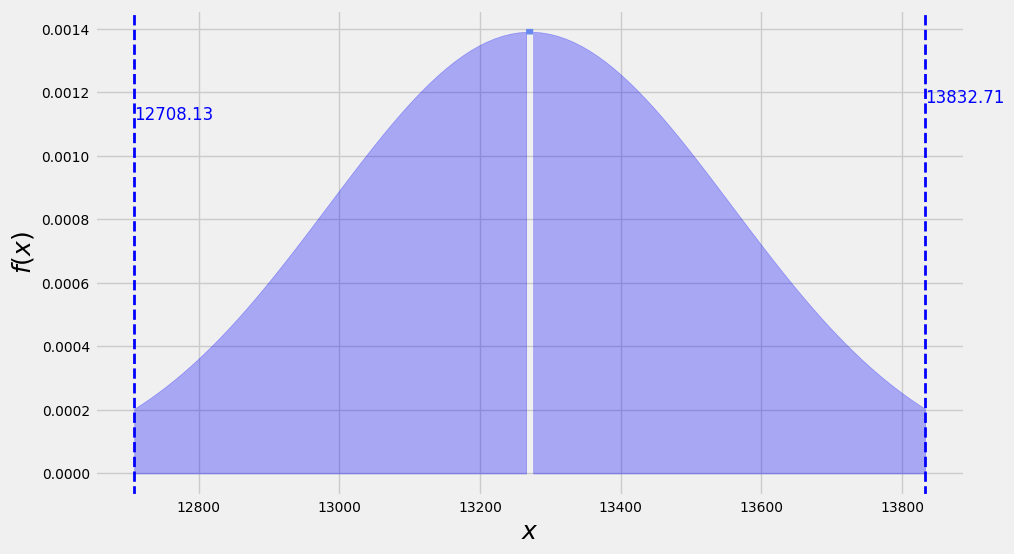

In [36]:
norm_conf_int(0.05, mean_ch, std_ch, margin=5)

In [37]:
# подготовка данных для построения student-t доверительного интервала
pred = results.predict(X)
n = pred.count()
mean_ch = pred.mean()
std_ch = pred.std(ddof=1)/np.sqrt(n)
stats.t.interval(0.95, df=n-1, loc=mean_ch, scale=std_ch )


(12707.624021137153, 13833.220509145349)